My idea for image captioning implementation with GPT-2 and MobileNet V3.   
The data is MS-COCO, and the preprocessing refers to https://tensorflow.google.cn/tutorials/text/image_captioning.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi

In [1]:
%tensorflow_version 2.x

import os
import warnings
import time
import json
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Download and process the data.

In [ ]:
annotation_folder, image_folder = '/annotations/', '/train2014/'

if not os.path.exists(os.path.abspath('.')+annotation_folder):
  annotation_zip = keras.utils.get_file(
    'captions.zip',
    cache_subdir=os.path.abspath('.'),
    origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
    extract=True)
  
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

if not os.path.exists(os.path.abspath('.')+image_folder):
  image_zip = keras.utils.get_file(
    'train2014.zip',
    cache_subdir=os.path.abspath('.'),
    origin='http://images.cocodataset.org/zips/train2014.zip',
    extract=True)
  
  image_path = os.path.dirname(image_zip)+image_folder
  os.remove(image_zip)

annotations_dict = json.load(open(annotation_file, 'r'))
text_df = pd.DataFrame(annotations_dict['annotations'])
image_df = pd.DataFrame(annotations_dict['images'])
ann_df = pd.merge(text_df, image_df, 'inner', left_on=['image_id'], right_on=['id'])
ann_df = ann_df[['image_id', 'file_name', 'caption']].sort_values(['image_id'])
ann_df.to_csv('drive/My Drive/Python/Research/tasks/datasets/ms_coco/caption_train.csv', index=False)

In [ ]:
def hswish_activating(x):
  return x*tf.nn.relu6(x+np.float32(3))*np.float32(1./6.)


def hsigmoid_activating(x):
  return tf.nn.relu6(x+3.)*0.16667


class Bottleneck(keras.layers.Layer):
  def __init__(self, ln, size, stride, cin, cout, exp, caxis, act, squ=True, **kwargs):
    super(Bottleneck, self).__init__(**kwargs)
    self.div, self.cin, self.filter, self.stride, self.squeeze, self.exp = 8, cin, cout, stride, squ, int(cin*exp)
    self.act = {'hswish': hswish_activating, 'relu': tf.nn.relu}[act]
    self.conv1 = keras.layers.Conv2D(self.exp, 1, 1, 'same', use_bias=False, name=ln+'expand/')
    self.conv2 = keras.layers.DepthwiseConv2D(size, stride, 'same', use_bias=False, name=ln+'depthwise/')
    self.conv3 = keras.layers.Conv2D(cout, 1, 1, 'same', use_bias=False, name=ln+'project/')
    self.norm1 = keras.layers.BatchNormalization(caxis, 0.999, name=ln+'expand/BatchNorm/')
    self.norm2 = keras.layers.BatchNormalization(caxis, 0.999, name=ln+'depthwise/BatchNorm/')
    self.norm3 = keras.layers.BatchNormalization(caxis, 0.999, name=ln+'project/BatchNorm/')
    self.s1 = keras.layers.Conv2D(self.dividing(self.exp/4), 1, activation='relu', name=ln+'squeeze_excite/Conv/')
    self.s2 = keras.layers.Conv2D(self.exp, 1, activation=hsigmoid_activating, name=ln+'squeeze_excite/Conv_1/')
    self.pool = keras.layers.GlobalAveragePooling2D()

  def dividing(self, v, minv=None):
    valu1 = max(self.div if not minv else minv, int(v+self.div/2)//self.div*self.div)
    return valu1+self.div if valu1 < 0.9*v else valu1

  def propagating(self, x, training):
    x1 = self.act(self.norm1(self.conv1(x), training=training)) if self.cin != self.exp else x
    x1 = self.act(self.norm2(self.conv2(x1), training=training))
    h1 = tf.reshape(self.pool(x1), [-1, 1, 1, self.exp]) if self.squeeze else None
    x1 = x1*self.s2(self.s1(h1)) if self.squeeze else x1
    x1 = self.norm3(self.conv3(x1), training=training)
    return x+x1 if self.cin == self.filter and self.stride == 1 else x1


class MobileNet(keras.layers.Layer):
  def __init__(self, alpha, caxis, cate, act='hswish', param=None, **kwargs):
    super(MobileNet, self).__init__(**kwargs)
    self.act = hswish_activating if act == 'hswish' else act
    self.replacement = {'kernel': 'weights', 'bias': 'biases'}
    self.conv1 = keras.layers.Conv2D(16, 3, 2, 'same', use_bias=False, name='MobilenetV3/Conv/')
    self.conv2 = keras.layers.Conv2D(576, 1, use_bias=False, name='MobilenetV3/Conv_1/')
    self.conv3 = keras.layers.Conv2D(1024, 1, use_bias=False, name='MobilenetV3/Conv_2/')
    self.conv4 = keras.layers.Conv2D(cate, 1, use_bias=False, name='MobilenetV3/Logits/Conv2d_1c_1x1')
    self.norm1 = keras.layers.BatchNormalization(caxis, 0.999, 1e-3, name='MobilenetV3/Conv/'+'BatchNorm/')
    self.norm2 = keras.layers.BatchNormalization(caxis, 0.999, 1e-3, name='MobilenetV3/Conv_1/'+'BatchNorm/')
    self.pool = keras.layers.GlobalAveragePooling2D()
    self.param = [
      (16,),
      (16, 3, 2, 1, 'relu', True),
      (24, 3, 2, 72/16, 'relu', False),
      (24, 3, 1, 88/24, 'relu', False),
      (40, 5, 2, 4, 'hswish', True),
      (40, 5, 1, 6, 'hswish', True),
      (40, 5, 1, 6, 'hswish', True),
      (48, 5, 1, 3, 'hswish', True),
      (48, 5, 1, 3, 'hswish', True),
      (96, 5, 2, 6, 'hswish', True),
      (96, 5, 1, 6, 'hswish', True),
      (96, 5, 1, 6, 'hswish', True)] if not param else param
    self.encoder = [Bottleneck(
      'MobilenetV3/expanded_conv_'+str(i1-1)+'/' if i1 > 1 else 'MobilenetV3/expanded_conv/',
      self.param[i1][1],
      self.param[i1][2],
      self.param[i1-1][0]*alpha,
      self.param[i1][0]*alpha,
      self.param[i1][3],
      caxis,
      self.param[i1][4],
      self.param[i1][5]) for i1 in range(1, len(self.param))]

  def loading(self, ckpt):
    _ = self.propagating(tf.ones((2, 224, 224, 3)))
    r1 = re.compile('|'.join(map(re.escape, self.replacement)))
    n1 = [r1.sub((lambda x1: self.replacement[x1.group(0)]), i1.name[:-2]) for i1 in self.weights]
    keras.backend.batch_set_value(zip(self.weights, [tf.train.load_variable(ckpt, i1) for i1 in n1]))

  @tf.function
  def propagating(self, x, training=False):
    x1 = self.act(self.norm1(self.conv1(x), training=training))

    for i1 in self.encoder:
      x1 = i1.propagating(x1, training)

    return self.act(self.norm2(self.conv2(x1), training=training))


mobile_net = MobileNet(1, -1, 1001)
mobile_net.loading('drive/My Drive/Python/Research/models/v3_small_float/model-388500')

In [ ]:
def image_loading(ipath):
  i1 = tf.image.decode_jpeg(tf.io.read_file(ipath), channels=3)
  return tf.image.resize(i1, (224, 224)), ipath


img_dataset = tf.data.Dataset.from_tensor_slices([image_path+i1 for i1 in ann_df['file_name'].unique().tolist()])
img_dataset = img_dataset.map(image_loading, num_parallel_calls=tf.data.AUTOTUNE).batch(64)
feature_set, batch_count = None, 0

for img_batch, path_batch in img_dataset:
  feature_batch = np.array(mobile_net.propagating(img_batch/255.))
  feature_set = feature_batch if feature_set is None else np.concatenate([feature_set, feature_batch])
  batch_count = batch_count+1

  if batch_count % 1000 == 0:
    print(str(batch_count)+' batches processed.')
  
np.save('drive/My Drive/Python/Research/tasks/datasets/ms_coco/image_train.npy', feature_set)

Build and train the model.

In [2]:
os.chdir('./drive/My Drive/Python/Research')
import mymodels as mm

VOCAB = './models/gpt_base_en/encoder.json'
GCONFIG = './models/gpt_base_en/hparams.json'
GCKPT = './models/gpt_base_en/model.ckpt'
MCKPT = './models/v3_small_float/model-388500'
LRATE = 1e-4
MAXLEN = 31
BATCH = 32
EPOCH = 1

In [ ]:
def data_processing(text, image, tokenizer, maxlen, batch, training, start, end, num):
  text1, label1, mask1, image1 = [], [], [], []

  for i1, j1 in enumerate(text['image_id'].unique().tolist()[start:end]):
    subset1 = random.sample(text[text['image_id'] == j1]['caption'].tolist(), num)

    for i2 in subset1:
      text2, _, mask2, len1 = tokenizer.encoding(i2, None, maxlen+1, length=True)
      
      if len1 < maxlen-1:
        text1, label1, mask1 = text1+[text2[:-1]], label1+[text2[1:]], mask1+[mask2[1:]]
        image1.append(image[i1:i1+1])

  image1 = np.concatenate(image1)
  text1, mask1, label1 = np.array(text1), np.array(mask1), np.array(label1)
  data1 = tf.data.Dataset.from_tensor_slices((image1, text1, mask1, label1))
  return data1.shuffle(len(text1)).batch(batch) if training else data1.batch(batch)


gpt_tokenizer = mm.Tokenizer(False, False, False)
gpt_tokenizer.loading(VOCAB)
image_train = np.load('tasks/datasets/ms_coco/image_train.npy')
text_train = pd.read_csv('tasks/datasets/ms_coco/caption_train.csv')
train_set = data_processing(text_train, image_train, gpt_tokenizer, MAXLEN, BATCH, True, 0, 30000, 2)
dev_set = data_processing(text_train, image_train, gpt_tokenizer, MAXLEN, BATCH, False, 80000, 85000, 2)
train_step = EPOCH*((30000*2//BATCH)+2)
del image_train

In [3]:
class Attention(mm.Attention):
  def __init__(self, **kwargs):
    super(Attention, self).__init__(**kwargs)

  def propagating(self, x, past=None, image=None, training=False):
    q1, k1, v1 = tf.split(self.wq(self.norm(x)), 3, 2)
    k1 = tf.concat([image[0], k1], -2) if image is not None else k1
    v1 = tf.concat([image[1], v1], -2) if image is not None else v1
    k2 = tf.concat([past[:, 0], k1], -2) if past is not None else k1
    v2 = tf.concat([past[:, 1], v1], -2) if past is not None else v1
    p1 = tf.stack([k1, v1], 1)
    m1 = tf.range(tf.shape(q1)[1])[:, tf.newaxis] < tf.range(tf.shape(k2)[1])-tf.shape(k2)[1]+tf.shape(q1)[1]
    x1, a1 = self.calculating(q1, k2, v2, m1, True, training)
    x1 = tf.reshape(tf.transpose(x1, [0, 2, 1, 3]), [-1, tf.shape(x1)[2], self.dim])
    return x+self.drop(self.dense(x1), training=training), a1, p1


class TransEncoder(mm.TransEncoder):
  def __init__(self, **kwargs):
    super(TransEncoder, self).__init__(**kwargs)
    self.att = Attention(
      bname=kwargs['bname'], lname=kwargs['lname'], head=kwargs['head'], size=kwargs['size'], mlm=False)

  def propagating(self, x, past=None, image=None, training=False):
    x1, a1, p1 = self.att.propagating(x, past, image, training)
    x2 = self.drop(self.dense2(self.dense1(x1 if self.mlm else self.norm(x1))), training=training)
    return self.norm(x1+x2) if self.mlm else (x1+x2, p1)


class GPT2(mm.GPT):
  def __init__(self, **kwargs):
    super(GPT2, self).__init__(**kwargs)
    self.encoder = [TransEncoder(
      bname='model/h'+str(i1),
      lname=['/attn/c_attn', '', '', '/attn/c_proj', '/lnorm_1', '/mlp/c_fc', '/mlp/c_proj', '/lnorm_2'],
      head=self.param['n_head'],
      size=self.param['n_embd']//self.param['n_head'],
      dff=self.param['n_embd']*4,
      act=self.param.get('activation', mm.gelu_activating),
      mlm=False) for i1 in range(self.param['n_layer'])]

  def propagating(self, x, pos=None, past=None, image=None, training=False, softmax=True):
    p1, p2 = (tf.unstack(past, axis=1) if past is not None else [None]*self.param['n_layer']), []
    t1 = pos if pos is not None else tf.repeat([past.shape[3]], x.shape[0], 0) if past is not None else None
    x1 = self.embedding.propagating(x, None, t1, training)

    for i1 in range(self.param['n_layer']):
      x1, a1 = self.encoder[i1].propagating(x1, p1[i1], None if image is None else image[i1], training)
      p2.append(a1)

    x1, h1 = self.norm(x1), tf.stack(p2, 1)
    x2 = tf.matmul(x1, self.embedding.emb, transpose_b=True)
    return tf.nn.softmax(x2) if softmax else x2, x1, h1

  @tf.function
  def calling(self, x, image):
    return self.propagating(x, None, None, image, False, False)

  @tf.function(experimental_relax_shapes=True)
  def iterating(self, x, pos, past):
    return self.propagating(x, pos, past, None, False, False)

  @tf.function(experimental_relax_shapes=True)
  def calculating(self, score, cur, beam, k, p, length, penalty, first):
    return super(GPT2, self).calculating(score, cur, beam, k, p, length, penalty, first)

  def generating(self, x, pos, image=None, beam=5, k=1, p=0.9, temp=1.0, penalty=1.0, maxlen=10, best=False):
    x1, b1, p1 = x, x.shape[0], tf.repeat(pos, beam, 0)
    scor1, leng1, past1, fini1, pred1 = 0., tf.cast(pos, tf.float32)+1., None, None, None
    list1, list2, i1 = np.arange(b1), [None]*b1, 0
    mask1 = tf.repeat(tf.one_hot([self.eos], self.param['n_vocab'], 0., self.ninf), b1*beam, 0)
    appe1 = tf.one_hot([self.eos], self.param['n_vocab'], 0., 1.)

    while i1 < maxlen and len(list1) > 0:
      x2, _, h1 = self.iterating(x1, p1+i1, past1) if i1 else self.calling(x1, image)
      s1 = tf.nn.log_softmax(tf.squeeze(x2/temp, 1)+fini1*mask1 if i1 else tf.gather_nd(x2/temp, pos, 1))
      x1, h2, scor1, leng1 = self.calculating(scor1+s1, s1, beam, k, p, leng1+appe1, penalty, i1 == 0)
      past1 = tf.gather(tf.concat([past1, h1], -2) if i1 else h1, h2)
      pred1, i1 = tf.concat([tf.gather(pred1, h2), x1], -1) if i1 else x1, i1+1
      e1, e2, fini1, list1, list2 = self.updating(x1, pred1, list1, list2, beam, i1 == maxlen)

      if len(e1) > 0 and i1 < maxlen:
        x1, p1, past1, scor1, leng1, mask1, fini1, pred1 = [
          tf.gather(j1, e2) for j1 in [x1, p1, past1, scor1, leng1, mask1, fini1, pred1]]

    return [[i1[0]] for i1 in list2] if best else list2


class MobileNet3(mm.MobileNet):
  def __init__(self, **kwargs):
    super(MobileNet3, self).__init__(**kwargs)

  @tf.function(experimental_relax_shapes=True)
  def propagating(self, x, training=False):
    x1 = self.act(self.norm1(self.conv1(x), training=training))

    for i1 in self.encoder:
      x1 = i1.propagating(x1, training)

    return self.act(self.norm2(self.conv2(x1), training=training))


class ConvBlock(keras.layers.Layer):
  def __init__(self, ln, channel, act, **kwargs):
    super(ConvBlock, self).__init__(**kwargs)
    self.act = {'hswish': mm.hswish_activating, 'relu': tf.nn.relu}[act]
    self.conv1 = keras.layers.Conv2D(channel, 1, 1, 'same', use_bias=False, name=ln+'conv/')
    self.conv2 = keras.layers.DepthwiseConv2D(3, 1, 'same', use_bias=False, name=ln+'depthwise/')
    self.norm1 = mm.Normalization('instance', init=tf.random_normal_initializer(1., 0.02), name=ln+'cnorm/')
    self.norm2 = mm.Normalization('instance', init=tf.random_normal_initializer(1., 0.02), name=ln+'dnorm/')

  def propagating(self, x):
    x1 = self.act(self.norm1(self.conv1(x)))
    return x+self.act(self.norm2(self.conv2(x1)))


class Caption(keras.Model):
  def __init__(self, vocab, gconfig, gckpt, mckpt=None, cin=576, simple=True, **kwargs):
    super(Caption, self).__init__(**kwargs)
    self.wk, self.wv, self.norm, self.enc, self.simple = [], [], [], [], simple
    self.tokenizer = mm.Tokenizer(False, False, False)
    self.tokenizer.loading(vocab)
    self.gpt = GPT2(config=gconfig)
    self.gpt.loading(gckpt)

    for i1 in range(self.gpt.param['n_layer']):
      self.wk.append(keras.layers.Dense(self.gpt.param['n_embd'], name='ienc/k'+str(i1)))
      self.wv.append(keras.layers.Dense(self.gpt.param['n_embd'], name='ienc/v'+str(i1)))
      self.norm.append(keras.layers.LayerNormalization(-1, 1e-6, name='ienc/nm'+str(i1)))
      self.enc += [ConvBlock('ienc/l'+str(i1), cin, 'hswish')] if simple else [
        mm.Bottleneck('ienc/l'+str(i1), 3, 1, cin, cin, 2, -1, 'hswish')]

    if mckpt:
      self.mobile = MobileNet3(alpha=1, caxis=-1, cate=1001)
      self.mobile.loading(mckpt)

  def encoding(self, feature, training):
    x1, s1, h1 = feature, tf.shape(feature), []

    for i1 in range(self.gpt.param['n_layer']):
      x1 = self.enc[i1].propagating(x1) if self.simple else self.enc[i1].propagating(x1, training)
      x2 = self.norm[i1](tf.reshape(x1, [-1, s1[1]*s1[1], s1[-1]]))
      h1.append([self.wk[i1](x2), self.wv[i1](x2)])

    return h1

  def propagating(self, feature, text, training=False, softmax=True):
    x1 = self.encoding(feature, training)
    return self.gpt.propagating(text, image=x1, training=training, softmax=softmax)

  def generating(self, image, maxlen, minlen):
    x1, s1 = self.encoding(self.mobile.propagating(image), False), int(tf.shape(image)[0])
    x2, p1, d1 = np.array([[self.gpt.eos]]*s1), np.array([[0]]*s1), ['']*s1
    g1 = self.gpt.generating(x2, p1, x1, maxlen=maxlen, best=False)

    for i1, j1 in enumerate(g1):
      clen1 = 0

      for k1 in j1:
        leng1, text1 = len(k1[:(k1+[self.gpt.eos]).index(self.gpt.eos)]), self.tokenizer.decoding(k1)
        d1[i1], clen1 = (text1, leng1) if leng1 > min(minlen-1, clen1) else (d1[i1], clen1)

        if leng1 >= minlen:
          break

    return d1, g1


@tf.function
def step_training(x, feature, y, mask):
  with tf.GradientTape() as tape1:
    pred1 = model_cap.propagating(feature, x, True, True)[0]
    mask1 = 1.-tf.cast(mask, tf.float32)
    loss1 = tf.reduce_sum(loss_function(y, pred1)*mask1)/tf.reduce_sum(mask1)

  grad1 = tape1.gradient(loss1, model_cap.trainable_variables)
  grad1, _ = tf.clip_by_global_norm(grad1, 1.0)
  adam_optimizer.apply_gradients(zip(grad1, model_cap.trainable_variables))
  training_loss(loss1)
  training_acc(y, pred1, sample_weight=mask1)


@tf.function
def step_evaluating(x, feature, y, mask):
  pred1 = model_cap.propagating(feature, x, False, True)[0]
  mask1 = 1.-tf.cast(mask, tf.float32)
  dev_acc(y, pred1, sample_weight=mask1)

In [ ]:
model_cap = Caption(VOCAB, GCONFIG, GCKPT)
adam_optimizer = mm.AdamW(train_step, LRATE, lmode=2, ldecay={'ienc': 10.})
loss_function = keras.losses.SparseCategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
training_loss = tf.keras.metrics.Mean(name='training_loss')
training_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='training_accuracy')
dev_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='dev_accuracy')
log_info = 'Training loss is {:.4f}, and accuracy is {:.4f}.'
end_info = 'Dev accuracy is {:.4f}, and epoch cost is {:.4f}.'

for epoch_count in range(EPOCH):
  print('Epoch {} running.'.format(epoch_count+1))
  step_count, time_point = 0, time.time()

  for image_x, text_x, the_mask, the_label in train_set:
    step_training(text_x, image_x, the_label, the_mask)
    step_count = step_count+1

    if step_count % 200 == 0:
      print(log_info.format(float(training_loss.result()), float(training_acc.result())))

  for image_x, text_x, the_mask, the_label in dev_set:
    step_evaluating(text_x, image_x, the_label, the_mask)

  print(end_info.format(float(dev_acc.result()), time.time()-time_point))
  print('**********')
  training_acc.reset_states()
  dev_acc.reset_states()

Epoch 1 running.
Training loss is 3.4862, and accuracy is 0.3706.
Training loss is 3.0990, and accuracy is 0.4119.
Training loss is 2.9186, and accuracy is 0.4321.
Training loss is 2.8118, and accuracy is 0.4445.
Training loss is 2.7356, and accuracy is 0.4543.
Training loss is 2.6796, and accuracy is 0.4611.
Training loss is 2.6337, and accuracy is 0.4667.
Training loss is 2.5947, and accuracy is 0.4715.
Training loss is 2.5626, and accuracy is 0.4760.
Dev accuracy is 0.4280, and epoch cost is 926.3502.
**********


In [ ]:
model_cap.save_weights('tasks/models/ms_coco/model')

Generate caption from a batch.

In [4]:
model_cap = Caption(VOCAB, GCONFIG, GCKPT)
model_cap.load_weights('tasks/models/ms_coco/model')
model_cap.mobile = MobileNet3(alpha=1, caxis=-1, cate=1001)
model_cap.mobile.loading(MCKPT)

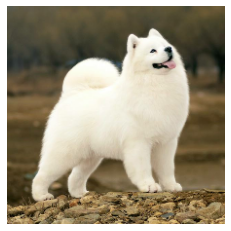

 A white polar bear standing on top of a rock.


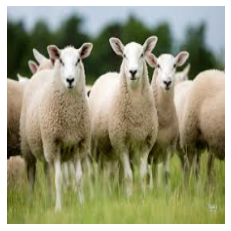

 A herd of sheep standing next to each other in a field.


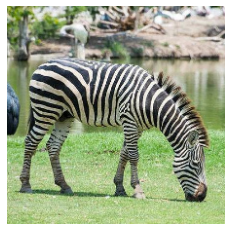

 A group of zebras grazing in a grassy field.


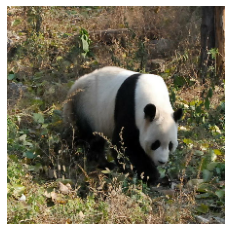

 A black and white cow standing in a grassy field.


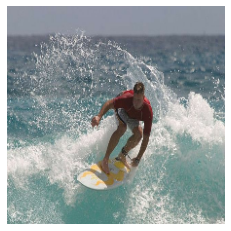

 A man riding a wave on top of a surfboard.


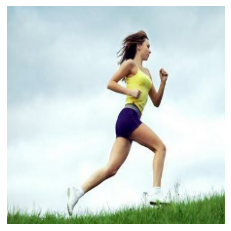

 A woman holding a tennis racquet on a tennis court.


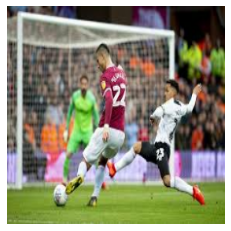

 A group of men playing a game of soccer.


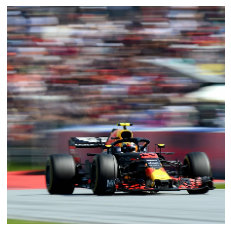

 A motorcycle is parked on the side of the road.


In [5]:
img_test = []

for img_id in [
  'models/v3_small_float/files/samoyed.jpg',
  'models/v3_small_float/files/sheep.jpg',
  'models/v3_small_float/files/zebra.jpg',
  'models/v3_small_float/files/panda.jpg',
  'models/v3_small_float/files/surfing.jpg',
  'models/v3_small_float/files/running.jpg',
  'models/v3_small_float/files/soccer.jpg',
  'models/v3_small_float/files/racing.jpg']:
  img_sample = tf.image.decode_jpeg(tf.io.read_file(img_id), 3)
  img_test.append(tf.expand_dims(tf.image.resize(tf.cast(img_sample, tf.float32)/255., [224, 224]), 0))

img_input = tf.concat(img_test, axis=0)
cap_test = model_cap.generating(img_input, 30, 5)[0]

for img_id in range(len(img_test)):
  plt.imshow(img_test[img_id][0])
  plt.axis('off')
  plt.show()
  print(cap_test[img_id])